In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from triplet_preparation import inputs_from_tuples, tuples_from_file_array, train_inputs_file_array_generator, train_inputs_length
from model_architecture import triplet_network_model, triplet_accuracy

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

tf.__version__, tf.keras.__version__

('2.1.0', '2.2.4-tf')

In [3]:
'''Initialize and use triplet network'''
input_shape = (773,)
embedding_size = 10
model, ea, ep, en = triplet_network_model(input_shape, embedding_size, hidden_layers=[512,256,64])
optimizer = keras.optimizers.Adam(lr = 0.00006)
model.compile(
    loss=None,
    optimizer=optimizer #,
    #metrics=[triplet_accuracy([ea,ep,en])]
)
model.summary()

Model: "embedding_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer_0 (Dense)    (None, 512)               396288    
_________________________________________________________________
embedding_layer_1 (Dense)    (None, 256)               131328    
_________________________________________________________________
embedding_layer_3 (Dense)    (None, 10)                2570      
Total params: 530,186
Trainable params: 530,186
Non-trainable params: 0
_________________________________________________________________
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 773)]        0                                            
_______________________________________________________________

In [7]:
train_files = [
	os.path.abspath('../data/samples/lichess_db_standard_rated_2020-02-06-tuples-strong.h5'),
	os.path.abspath('../data/samples/lichess_db_standard_rated_2013-02-tuples.h5')
]

validation_files = [
	os.path.abspath('../data/samples/lichess_db_standard_rated_2013-01-tuples.h5')
]

batch_size = 16
steps_per_epoch = 1000
yield_augmented = 1

train_len = train_inputs_length(train_files, table_id_prefix="tuples")
print(f"{train_len} training samples.")

train_generator = train_inputs_file_array_generator(train_files, table_id_prefix="tuples",
					tuple_indices=[0,1,2,3,4,5,6], batch_size=batch_size)
print(len(next(train_generator)),next(train_generator)[0].shape)

validation_generator = train_inputs_file_array_generator(validation_files, table_id_prefix="tuples",
					tuple_indices=[0,1,2,3,4,5,6], batch_size=batch_size)

#validation_data = next(validation_generator)
#print(len(validation_data), validation_data[0].shape)

history = model.fit(
	train_generator,
	steps_per_epoch=steps_per_epoch,
    epochs=int(yield_augmented*train_len/steps_per_epoch/batch_size),
	validation_data=validation_generator,
	validation_steps=10)


436049 training samples.
3 (16, 773)
Train for 1000 steps, validate for 10 steps
Epoch 1/27
1000/1000 [==============================] - 9s 9ms/step - loss: 0.5096 - val_loss: 0.6509
Epoch 2/27
1000/1000 [==============================] - 9s 9ms/step - loss: 0.3178 - val_loss: 0.3745
Epoch 3/27
1000/1000 [==============================] - 9s 9ms/step - loss: 0.4500 - val_loss: 0.2980
Epoch 4/27
1000/1000 [==============================] - 9s 9ms/step - loss: 0.4049 - val_loss: 0.2127
Epoch 5/27
1000/1000 [==============================] - 9s 9ms/step - loss: 0.3340 - val_loss: 0.3738
Epoch 6/27
1000/1000 [==============================] - 9s 9ms/step - loss: 0.3071 - val_loss: 0.4352
Epoch 7/27
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2892 - val_loss: 0.2719
Epoch 8/27
1000/1000 [==============================] - 10s 10ms/step - loss: 0.2604 - val_loss: 0.4734
Epoch 9/27
1000/1000 [==============================] - 9s 9ms/step - loss: 0.2365 - val_loss: 0.21


history dict: dict_keys(['loss', 'val_loss'])


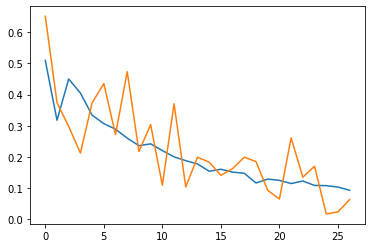

In [10]:
print('\nhistory dict:', history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(np.arange(len(loss)),loss)
plt.plot(np.arange(len(val_loss)),val_loss)

In [ ]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate([anc_test, pos_test, neg_test], batch_size=128)
print('test loss:', results)

### OLD

In [ ]:
'''Create Checkpoints during training'''

checkpoint_path = "checkpoints/test_cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Train the model with the new callback
history = model.fit(train_images, 
                    train_labels,  
                    epochs=10,
                    validation_data=(test_images,test_labels),
                    callbacks=[cp_callback])  # Pass callback to training


In [ ]:
'''Loads the weights from checkpoint path'''
model = create_model()
model.load_weights(checkpoint_path)

In [ ]:
'''Save the complete model after training'''
model.save('model/test_model', save_format='tf') # or save_format='h5'

In [ ]:
'''Load model from saved state'''
model = tf.keras.models.load_model('model/test_model')
model.summary()

In [ ]:
'''Use loaded model for inference'''
loss, acc = model.evaluate(test_images,  test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))
print(model.predict(test_images).shape)